Final Project by Alicia Bergeron and Nick Arangio

Installation instructions, create pip venv, and install all required files using requirements.txt

Once done, ensure you are in the correct env in terminal and type the following:

python -m ipykernel intall --user --name:[env name]

In [190]:
import argparse
import functools
import logging

import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import Counter

import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions import constraints

import nltk
from nltk.corpus import stopwords

import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, SVI, Trace_ELBO, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.optim import Adam, ClippedAdam

stop = set(stopwords.words('english'))
pyro.set_rng_seed(0)
logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

### Dataset Information
Sentiments: sadness, anger, love, surprise, fear, joy

In [191]:
dataset = 'Emotions dataset for NLP/train.txt'

NLTK Tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [192]:
df = pd.read_csv(dataset, sep=';', header=None)
df.columns = ["Text", "Sentiment"]
display(df.head())
display(df.Sentiment.unique())
display(df.describe())

def filter(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return " ".join([lemmatizer.lemmatize(word) for word in str(text).split() if word not in stop])

df.Text = df.Text.apply(lambda t: filter(t))

,Text,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

,Text,Sentiment
count,16000,16000
unique,15969,6
top,i feel on the verge of tears from weariness i ...,joy
freq,2,5362


In [193]:
df.head()

,Text,Sentiment
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger


In [199]:
vocab = Counter()
df.Text.str.lower().str.split().apply(vocab.update)
vocab

Counter({'feel': 11506,
         'feeling': 5455,
         'like': 2918,
         'im': 2430,
         'time': 974,
         'really': 942,
         'know': 872,
         'get': 778,
         'make': 769,
         'little': 736,
         'want': 681,
         'day': 675,
         'thing': 672,
         'people': 664,
         'one': 647,
         'would': 646,
         'think': 609,
         'life': 605,
         'still': 596,
         'ive': 587,
         'even': 568,
         'way': 528,
         'bit': 521,
         'something': 513,
         'love': 512,
         'much': 496,
         'going': 489,
         'dont': 482,
         'could': 453,
         'need': 442,
         'go': 431,
         'back': 406,
         'good': 401,
         'pretty': 392,
         'say': 362,
         'see': 359,
         'always': 355,
         'right': 353,
         'work': 346,
         'friend': 340,
         'also': 337,
         'year': 336,
         'today': 332,
         'around': 315,
         

In [200]:
vocab['feel']

11506

In [195]:
dfA = df
dfA.Sentiment = dfA.Sentiment.map({
    'sadness':1,
    'anger':2,
    'love':3,
    'surprise':4,
    'fear':5,
    'joy':6
}
)

In [196]:
dfA

,Text,Sentiment
0,didnt feel humiliated,1
1,go feeling hopeless damned hopeful around some...,1
2,im grabbing minute post feel greedy wrong,2
3,ever feeling nostalgic fireplace know still pr...,3
4,feeling grouchy,2
...,...,...
15995,brief time beanbag said anna feel like beaten,1
15996,turning feel pathetic still waiting table subb...,1
15997,feel strong good overall,6
15998,feel like rude comment im glad,2


In [211]:
analysis = {}
for index, row in dfA.iterrows():
    for w in str(row['Text']).split():
        if w in analysis:
            analysis[w] += row['Sentiment']
        else:
            analysis [w] = row['Sentiment']
print(analysis)

{'didnt': 863, 'feel': 41266, 'humiliated': 55, 'go': 1602, 'feeling': 19041, 'hopeless': 84, 'damned': 11, 'hopeful': 334, 'around': 1154, 'someone': 854, 'care': 392, 'awake': 74, 'im': 8714, 'grabbing': 16, 'minute': 234, 'post': 502, 'greedy': 133, 'wrong': 208, 'ever': 823, 'nostalgic': 161, 'fireplace': 15, 'know': 2947, 'still': 1996, 'property': 12, 'grouchy': 58, 'ive': 1949, 'little': 2624, 'burdened': 66, 'lately': 330, 'wasnt': 323, 'sure': 968, 'taking': 331, 'milligram': 4, 'time': 3503, 'recommended': 4, 'amount': 137, 'fallen': 21, 'asleep': 59, 'lot': 907, 'faster': 44, 'also': 1295, 'like': 10265, 'funny': 253, 'confused': 288, 'life': 2115, 'teenager': 69, 'jaded': 53, 'year': 1255, 'old': 424, 'man': 329, 'petronas': 12, 'performed': 10, 'well': 1221, 'made': 1040, 'huge': 107, 'profit': 17, 'romantic': 157, 'make': 2960, 'suffering': 57, 'seeing': 219, 'mean': 514, 'something': 1900, 'running': 235, 'divine': 357, 'experience': 379, 'expect': 117, 'type': 165, 'spi

In [212]:
for key in analysis:
    # print(analysis[key])
    # print(key)
    analysis[key] = [analysis[key] / vocab[key], vocab[key]]


In [238]:
new_analysis = {k: v for k, v in analysis.items() if v[1] <= 300}
outliers = {k: v for k, v in analysis.items() if v[1] > 300}
print(outliers)


{'go': [3.7169373549883993, 431], 'around': [3.6634920634920634, 315], 'know': [3.3795871559633026, 872], 'still': [3.348993288590604, 596], 'ive': [3.320272572402044, 587], 'little': [3.5652173913043477, 736], 'time': [3.5965092402464065, 974], 'also': [3.8427299703264093, 337], 'life': [3.4958677685950414, 605], 'year': [3.7351190476190474, 336], 'make': [3.849154746423927, 769], 'something': [3.7037037037037037, 513], 'think': [3.5697865353037765, 609], 'really': [3.522292993630573, 942], 'pretty': [3.936224489795918, 392], 'work': [3.7427745664739884, 346], 'thing': [3.3333333333333335, 672], 'dont': [3.387966804979253, 482], 'love': [3.794921875, 512], 'always': [3.636619718309859, 355], 'people': [3.552710843373494, 664], 'need': [3.6063348416289593, 442], 'get': [3.501285347043702, 778], 'day': [3.525925925925926, 675], 'much': [3.586693548387097, 496], 'would': [3.442724458204334, 646], 'want': [3.5066079295154187, 681], 'bit': [3.2399232245681384, 521], 'cant': [2.990033222591

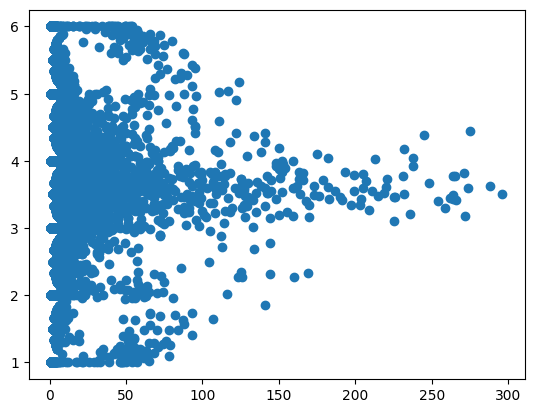

In [239]:
txt = new_analysis.keys
values = list(new_analysis.values())
fig, ax = plt.subplots()
ax.scatter([item[1] for item in values], [item[0] for item in values])


### Variable Definitions:
N = number of unique words in total vocabulary
T = numebr of topics in total document of twweets
alpha = parameter 

In [48]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return F.pad(beta, (0, 1), value=1) * F.pad(beta1m_cumprod, (1, 0), value=1)

tensor([0.4590, 0.7924, 0.4410, 0.4730, 0.1489, 0.6554])
tensor([[ 1.0835, -1.7557],
        [ 0.6740, -2.5884],
        [ 5.7803,  2.1616],
        [ 2.9464, -0.1498],
        [-0.1059,  0.3602],
        [ 2.8846,  0.5205],
        [ 4.1477, -1.9920]])
tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 2, 0, 5, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0])


In [44]:
def model(data):

    # T-1 conditionally independent Beta distributions of B
    with pyro.plate("beta_plate", T-1): 
        beta = pyro.sample("beta", dist.Beta(1, alpha)) 

    # T conditionally independent priors
    with pyro.plate("mu_plate", T):
        mu = pyro.sample("mu", dist.MultivariateNormal(torch.zeros(2), 5 * torch.eye(2)))

    # N conditionally independent Categorical distributions for cluster assignment
    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(mix_weights(beta)))
        pyro.sample("obs", dist.MultivariateNormal(mu[z], torch.eye(2)), obs=data)

In [ ]:
def guide(data):
    kappa = pyro.param('kappa', lambda: dist.Uniform(0, 2).sample([T-1]), constraint=constraints.positive)
    tau = pyro.param('tau', lambda: dist.MultivariateNormal(torch.zeros(2), 3 * torch.eye(2)).sample([T]))
    phi = pyro.param('phi', lambda: dist.Dirichlet(1/T * torch.ones(T)).sample([N]), constraint=constraints.simplex)

    with pyro.plate("beta_plate", T-1):
        q_beta = pyro.sample("beta", dist.Beta(torch.ones(T-1), kappa))

    with pyro.plate("mu_plate", T):
        q_mu = pyro.sample("mu", dist.MultivariateNormal(tau, torch.eye(2)))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Categorical(phi))

In [ ]:
T = 10
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
losses = []

def train(num_iterations):
    pyro.clear_param_store()
    for j in tqdm(range(num_iterations)):
        loss = svi.step(data)
        losses.append(loss)

def truncate(alpha, centers, weights):
    threshold = alpha**-1 / 100.
    true_centers = centers[weights > threshold]
    true_weights = weights[weights > threshold] / torch.sum(weights[weights > threshold])
    return true_centers, true_weights

alpha = 0.1
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_01, Bayes_Weights_01 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

alpha = 1.5
train(1000)

# We make a point-estimate of our model parameters using the posterior means of tau and phi for the centers and weights
Bayes_Centers_15, Bayes_Weights_15 = truncate(alpha, pyro.param("tau").detach(), torch.mean(pyro.param("phi").detach(), dim=0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_01[:, 0], Bayes_Centers_01[:, 1], color="red")

plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], color="blue")
plt.scatter(Bayes_Centers_15[:, 0], Bayes_Centers_15[:, 1], color="red")
plt.tight_layout()
plt.show()


[1024, 100, 100, 8]


 69707858 Creating MLP with sizes [1024, 100, 100, 8]


Sequential(
  (0): Linear(in_features=1024, out_features=100, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=8, bias=True)
  (5): Sigmoid()
  (6): Softmax(dim=-1)
)